In [10]:
import numpy as np
import pandas as pd

from pathlib import Path

from ftplib import FTP

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-dark-palette')
%matplotlib inline

Below is code to automatically grab a file from the FTP for RNAcentral. FTPlib doesn't like large files though, so I ended up doing it manually. 

In [11]:
# HOSTNAME = 'ftp.ebi.ac.uk'

# ftp = FTP(HOSTNAME)

# ftp.login()

# ftp.cwd('pub/databases/RNAcentral/current_release/json')

# filename = 'ensembl-xref-1-100001.json'

# with open(filename, "w") as rna_json:
#     ftp.retrlines(f"RETR {filename}", rna_json.write)


Instead of automated requests, I grabbed a few of the JSON files from the FTP, which can be read in with the following function. 

In [12]:
def load_rna(fname, inc_other=True, merge_other=True, simple_descrips=False, drop=True):
    rna = pd.read_json(fname)
    
    # drop extra columns which reference external databases -- always
    rna = rna.drop(['xrefs', 'md5'], axis=1)
    
    # make the column names pretty
    cols = {'rnacentral_id': 'RNA ID', 'description': 'Description', 'sequence':'Sequence', 'rna_type': 'RNA Type', 'taxon_id': 'Taxon ID'}
    rna = rna.rename(columns=cols)
    
    # remove underscores from RNA type
    rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('_', ' ')), axis=1)
    
    # combine the 'other', 'misc', 'nc', and 'lnc' types\n",
    if merge_other:
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('misc RNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('ncRNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('lncRNA', 'other')), axis=1)

    # drop rows with unclassified RNAs? 
    if not inc_other:
        rna = rna[rna['RNA Type'] != 'other']
        
        if not merge_other:
            rna = rna[rna['RNA Type'] != 'misc RNA']
            rna = rna[rna['RNA Type'] != 'ncRNA']
            rna = rna[rna['RNA Type'] != 'lncRNA']
    
    # Remove everything except latin name from species description
    if simple_descrips:
        rna['Description'] = rna.apply(lambda row : (row['Description'].split(' ')[0] + ' ' + row['Description'].split(' ')[1]), axis=1)\
        
    # drop extra columns with unnecessary info -- optional
    if drop:
        rna = rna.drop(['Taxon ID', 'RNA ID', 'Description'], axis=1)
    
    return rna



In [13]:
# load a batch of data files from RNAcentral or load in a single file?
load_all = True

if load_all:
    p = Path()
    p = p / 'data'
    files = p.glob('ensembl-*')
    rna = pd.DataFrame()

    for file in files:
        try: 
            print(f'Loading data from {str(file)}')
            rna = pd.concat([rna, load_rna(str(file), inc_other=False, simple_descrips=True)])
        except:
            print(f'Could not load data from {str(file)}')

    print('All data loaded.')

else:
    rna = load_rna('data\ensembl-xref-34100001-34200001.json')


Loading data from data\ensembl-xref-10000001-10100001.json
Loading data from data\ensembl-xref-16500001-16600001.json
Loading data from data\ensembl-xref-22600001-22700001.json
Loading data from data\ensembl-xref-29100001-29200001.json
Loading data from data\ensembl-xref-29200001-29300001.json
Loading data from data\ensembl-xref-34100001-34200001.json
Loading data from data\ensembl-xref-6800001-6900001.json
Loading data from data\ensembl-xref-6900001-7000001.json
Loading data from data\ensembl-xref-7000001-7100001.json
Loading data from data\ensembl-xref-7100001-7200001.json
Loading data from data\ensembl-xref-7200001-7300001.json
Loading data from data\ensembl-xref-7300001-7400001.json
Loading data from data\ensembl-xref-7400001-7500001.json
Loading data from data\ensembl-xref-9400001-9500001.json
All data loaded.


In [14]:
rna.head()

,Sequence,RNA Type
0,GGAGGGTAAGCTCAGTGGTTAGAATACATGCTTAGCATGCAGGAGG...,tRNA
3,ATGCTAGCTTCAGCAGCACATATGCTAAAATTGGAATGATACAGAG...,snRNA
4,GCCGGGTGTGGTGGCTCACGCCTGTAATCCCAATAGTTTGGGAGGC...,sRNA
5,GCCGGGTGTGGTGGCTCACGCCTGTAATCCCAATAGTTTGGGAGGC...,sRNA
6,GCCGGGTGTGGCGGCGTGCACCTGTAGTCCCAGTTACTTGGAGGCT...,SRP RNA


In [15]:
merge_sequence = rna.groupby("Sequence").agg({'RNA Type':'first'}).reset_index()
print(len(rna))
print(len(merge_sequence))

739462
599910


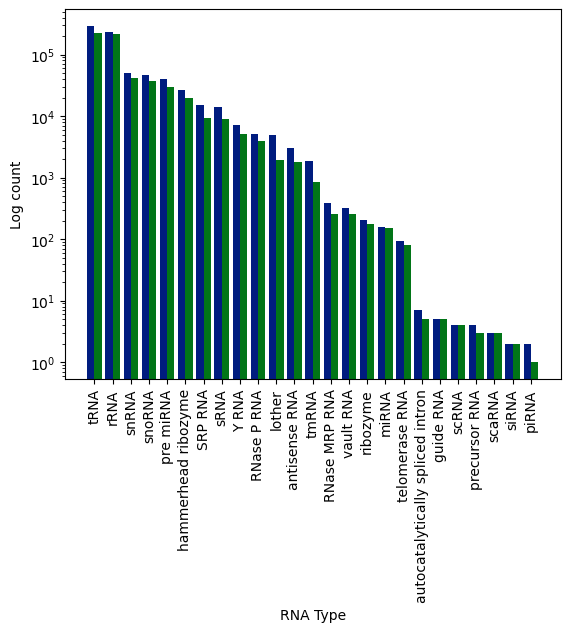

In [30]:
typcount = rna['RNA Type'].value_counts()
mtypcount = merge_sequence['RNA Type'].value_counts()
xpos = np.arange(0, 2*len(typcount.index), 2)

plt.bar(x=xpos, height=typcount, log=True, width=-0.8, align='edge', tick_label=typcount.index)

plt.bar(x=xpos, height=mtypcount, log=True, width=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('RNA Type')
plt.ylabel('Log count');